<a href="https://colab.research.google.com/github/yeahxne/Deep_Learning_2022/blob/main/Colab_Py37.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import matplotlib.pyplot as plt

# (8)learning rate decay
from torch.optim import lr_scheduler

batch_size=16
learning_rate=0.001
num_epoch=30

In [2]:
cifar_train=dset.CIFAR10("CIFAR10/",train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
cifar_test=dset.CIFAR10("CIFAR10/",train=False, transform=transforms.ToTensor(), target_transform=None, download=True)

# (2) data augmentation 
#cifar_train=dset.CIFAR10("CIFAR10/", train=True,
#                         transform=transforms.Compose([
#                            transforms.Resize(36),  
#                            transforms.CenterCrop(32),  
#                            transforms.RandomHorizontalFlip(),  
#                            transforms.Lambda(lambda x: x.rotate(90)),
#                            transforms.ToTensor()
#                         ]))

# (4) Data Normalization 
cifar_train=dset.CIFAR10("CIFAR10/", train=True,
                        transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)),
                        ])
                       , target_transform=None, download=False)

cifar_test=dset.CIFAR10("CIFAR10/", train=False,
                        transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)),
                        ])
                        , target_transform=None, download=False)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting CIFAR10/cifar-10-python.tar.gz to CIFAR10/
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


cifar_train 길이: 50000
cifar_test 길이: 10000
image data 형태: torch.Size([3, 32, 32])
label: 9


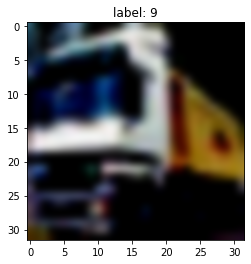

In [3]:
print("cifar_train 길이:", len(cifar_train))
print("cifar_test 길이:", len(cifar_test))

# 데이터 하나 형태
image, label = cifar_train.__getitem__(1)  # 1번째 데이터
print("image data 형태:", image.size())
print("label:", label)

# 그리기
img = image.numpy()  # image 타입을 numpy로 변환(3,32,32)

# (3,32,32) -> (32,32,3)
r, g, b = img[0,:,:], img[1,:,:], img[2,:,:]
# img = img.reshape(img.shape[1], img.shape[2], img.shape[0])
img2 = np.zeros((img.shape[1], img.shape[2], img.shape[0]))
img2[:,:,0], img2[:,:,1], img2[:,:,2] = r, g, b

plt.title("label: %d" %label)
plt.imshow(img2,interpolation='bicubic')
plt.show()

In [4]:
def ComputeAccr(dloader, imodel):
    correct = 0
    total = 0
    
    for j, [imgs, labels] in enumerate(dloader):  # batch_size 만큼
        img = Variable(imgs,volatile=True).cuda()  # x
        # label = Variable(labels)  # y
        label = Variable(labels).cuda()
        
        output = imodel.forward(img)  # forward prop.
        _, output_index = torch.max(output, 1)
        
        total += label.size(0)
        correct += (output_index == label).sum().float()

    accr = 100*correct/total
    accr = float(accr.cpu().numpy())
    print("Accuracy of Test Data: {}".format(accr))
    return accr

In [5]:
# === 3. 데이터 로드함수 ===
train_loader=torch.utils.data.DataLoader(list(cifar_train)[:], batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)
test_loader=torch.utils.data.DataLoader(cifar_test, batch_size=batch_size, shuffle=False, num_workers=2, drop_last=True)

# === 4. 모델 선언 ===
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.layer=nn.Sequential(
            nn.Conv2d(3,8,3,padding=1),  # 변경x
            nn.ELU(),
            # nn.PReLU(),
            # nn.LeakyReLU(),
            nn.Dropout2d(0.1),
            nn.BatchNorm2d(8),
            nn.Conv2d(8,32,3,padding=1),  # 변경x
            nn.ELU(),
            # nn.PReLU(),
            # nn.LeakyReLU(),
            nn.Dropout2d(0.1),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2,2),  # 변경x
            nn.Conv2d(32,64,3,padding=1),  # 변경x
            nn.ELU(),
            # nn.PReLU(),
            # nn.LeakyReLU(),
            nn.Dropout2d(0.3),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2,2)  # 변경x
        )
        self.fc_layer=nn.Sequential(
            nn.Linear(64*8*8, 100),
            nn.ELU(),
            # nn.PReLU(),
            # nn.LeakyReLU(),
            nn.Dropout2d(0.3),
            nn.BatchNorm1d(100),
            nn.Linear(100,10)
        )

        
        # (3) weight initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal(m.weight.data)
                # init.kaiming_normal(m.weight.data, nonlinearity='leaky_relu')
                m.bias.data.fill_(0)
            if isinstance(m, nn.Linear):
                init.kaiming_normal(m.weight.data)
                # init.kaiming_normal(m.weight.data, nonlinearity='leaky_relu')
                m.bias.data.fill_(0)
                
    def forward(self,x):
        out=self.layer(x)
        out=out.view(batch_size,-1)
        out=self.fc_layer(out)
        
        return out

model=CNN().cuda()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


In [8]:
# === 5. loss, optimizer ===
loss_func=nn.CrossEntropyLoss()
# optimizer=torch.optim.SGD(model.parameters(), lr=learning_rate)

# (6) Adam optimizer
optimizer=torch.optim.Adam(model.parameters(), lr=learning_rate)

# (7) learning rate decay
scheduler=lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.2)

model.train()  # train mode로 바꾸기 -> dropout, batch normalization에 영향을 줌.

# ===6. 학습 ===
for i in range(num_epoch):
    for j,[image, label] in enumerate(train_loader):
        x=Variable(image).cuda()
        y_=Variable(label).cuda()
        
        optimizer.zero_grad()
        output=model.forward(x)
        loss=loss_func(output,y_)
        loss.backward()
        optimizer.step()
        
        if j%1000==0:
            print(j,loss)

model.eval()  # evaluation(test) mode로 바꾸기 -> dropout, batch normalization에 영향을 줌.
ComputeAccr(test_loader, model)

# 학습된 파라미터 저장
netname = './my_net.pkl'
torch.save(model,netname, )

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


0 tensor(1.0953, device='cuda:0', grad_fn=<NllLossBackward0>)
1000 tensor(1.1463, device='cuda:0', grad_fn=<NllLossBackward0>)
2000 tensor(0.9557, device='cuda:0', grad_fn=<NllLossBackward0>)
3000 tensor(0.8578, device='cuda:0', grad_fn=<NllLossBackward0>)
0 tensor(0.8209, device='cuda:0', grad_fn=<NllLossBackward0>)
1000 tensor(0.8616, device='cuda:0', grad_fn=<NllLossBackward0>)
2000 tensor(1.5044, device='cuda:0', grad_fn=<NllLossBackward0>)
3000 tensor(1.2974, device='cuda:0', grad_fn=<NllLossBackward0>)
0 tensor(1.0218, device='cuda:0', grad_fn=<NllLossBackward0>)
1000 tensor(1.0982, device='cuda:0', grad_fn=<NllLossBackward0>)
2000 tensor(1.1855, device='cuda:0', grad_fn=<NllLossBackward0>)
3000 tensor(0.7806, device='cuda:0', grad_fn=<NllLossBackward0>)
0 tensor(1.0271, device='cuda:0', grad_fn=<NllLossBackward0>)
1000 tensor(0.7651, device='cuda:0', grad_fn=<NllLossBackward0>)
2000 tensor(1.1468, device='cuda:0', grad_fn=<NllLossBackward0>)
3000 tensor(0.7607, device='cuda:0', 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of Test Data: 76.3499984741211


In [25]:
netname = './my_net_final.pkl'
model = torch.load(netname)

# 성능 확인
ComputeAccr(test_loader,model)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Accuracy of Test Data: 76.69999694824219


76.69999694824219